<a href="https://colab.research.google.com/github/hannape/CNN-pierwsze-podejscie/blob/master/cnn_grid_with_scorer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title
import keras
from sklearn.metrics import roc_auc_score

class Histories(keras.callbacks.Callback):
	def on_train_begin(self, logs={}):
		self.aucs = []
		self.losses = []

	def on_train_end(self, logs={}):
		return

	def on_epoch_begin(self, epoch, logs={}):
		return

	def on_epoch_end(self, epoch, logs={}):
		self.losses.append(logs.get('loss'))
		y_pred = self.model.predict(self.validation_data[0])
		self.aucs.append(roc_auc_score(self.validation_data[1], y_pred))
		a = (roc_auc_score(self.validation_data[1], y_pred))
		print(" AUC_on_val: %f " % a)
		return

	def on_batch_begin(self, batch, logs={}):
		return

	def on_batch_end(self, batch, logs={}):    return
  
from google.colab import drive
drive.mount('/content/drive')


In [0]:
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function

import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.utils import class_weight
from sklearn.metrics import  make_scorer
from sklearn.metrics import log_loss
K.set_image_dim_ordering('th')
import numpy as np
from sklearn import preprocessing
import glob
import os
import random
import functools
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# num_classes = 2
X_train = numpy.load('drive/My Drive/X_train.npy')
y_train = numpy.load('drive/My Drive/y_train.npy')
X_test = numpy.load('drive/My Drive/X_test.npy')
y_test = numpy.load('drive/My Drive/y_test.npy')

X_train = X_train.reshape(X_train.shape[0], 1, 60, 87).astype('float32')
#X_val = X_val.reshape(X_val.shape[0], 1, 60, 87).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 60, 87).astype('float32')

input_shape = (1, 60, 87)
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(30581, 1, 60, 87) (30581,)
(10793, 1, 60, 87) (10793,)


In [0]:
#@title
def make_model(dense_layer_sizes, filters, kernel_size, pool_size):
    model = Sequential()
    model.add(Conv2D(filters, kernel_size,input_shape=input_shape, activation='relu'))
    #model.add(Activation('relu'))
    #model.add(Conv2D(filters, kernel_size))
    #model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten())
    #for layer_size in dense_layer_sizes:
    model.add(Dense(dense_layer_sizes))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    return model



In [0]:
c_w = { 0:0.02, 1:0.98}
index = ['r%d' % x for x in range(len(y_train))]
a = [c_w[class_label] for class_label in y_train]
sample_weight_frame = pd.DataFrame(a, index = index)
score_params = {"sample_weight": sample_weight_frame}
print(sample_weight_frame[0:5])


       0
r0  0.98
r1  0.02
r2  0.02
r3  0.02
r4  0.02


In [0]:
#class_weights = class_weight.compute_class_weight('balanced',numpy.unique(y_train),y_train)

### SCORERS
import functools
def my_score(y_true, y_pred, sample_weight): 
  return log_loss(y_true.values, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1), normalize=True)
    
def my_score2(sample_weight):  # <----------------wersja 2, implementowana w ten sposób by potem przy compile(loss=...) nie trzeba było podawać 3 argumentów (bo nie wiem jak nawet gdybym chciała)
  def loss_2_args(y_true, y_pred):  
      return log_loss(y_true.values, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1), normalize=True)   
  return loss_2_args

my_scorer = make_scorer(my_score,
                          greater_is_better=False, 
                          needs_threshold=False,
                          **score_params)

my_scorer2 = make_scorer(my_score2,
                          greater_is_better=False, 
                          needs_threshold=False,
                          **score_params)

my_loss = functools.partial(my_score, sample_weight=sample_weight_frame)  # za: https://github.com/keras-team/keras/issues/2115

# z https://github.com/keras-team/keras/issues/2115
from functools import partial, update_wrapper

def wrapped_partial(func, *args, **kwargs):
	partial_func = partial(func, *args, **kwargs)
	update_wrapper(partial_func, func)
	return partial_func

def binary_crossentropy_weigted(y_true, y_pred, class_weights):
	y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
	loss = K.mean(class_weights*(-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred)),axis=-1)
	return loss

custom_loss = wrapped_partial(binary_crossentropy_weigted, class_weights=np.array([0.02, 0.98]))

## AUC METRIC

def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
  
auc_roc = as_keras_metric(tf.metrics.auc)


In [0]:
#@title
import tensorflow

from tensorflow.python.ops import clip_ops
from tensorflow.python.framework import dtypes as dtypes_module
from tensorflow.python.util.tf_export import tf_export
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
@tf_export('keras.backend.dtype')
def dtype(x):
  return x.dtype.base_dtype.name

_EPSILON = 1e-7
def epsilon():
  return _EPSILON

def _to_tensor(x, dtype):
  return ops.convert_to_tensor(x, dtype=dtype)

def binary_crossentropy(target, output, from_logits=False):
  if not from_logits:
    # transform back to logits
   
    #epsilon_ = tensorflow.convert_to_tensor(epsilon(), np.float32)
    #output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
    output = math_ops.log(output / (1 - output))
  return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

In [0]:
sample_weight = sample_weight_frame
def mean_squared_error2(y_true, y_pred):   ## taka działa w compile
  return K.mean(K.square(y_pred*2 - y_true), axis=-1)

def loss_2_args_new(y_true, y_pred):    ## a czemu taka nie?
  return log_loss(y_true.values, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1), normalize=True)

def make_model_modified(dense_layer_sizes,filters, kernel_size,pool_size):

    #dense_layer_sizes= 128
    #filters = 20
    #kernel_size = [3,3]
    #pool_size = [2,2]
        
    model = Sequential()
    model.add(Conv2D(filters, kernel_size,input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
   
    model.add(Flatten())
    model.add(Dense(dense_layer_sizes, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=custom_loss,#'binary_crossentropy',#loss_2_args(y_true, y_pred)'',#loss='binary_crossentropy'
                  # co tu powinno wejść? o samo co do scoring w GridSearchCv? chyba nie: https://stackoverflow.com/questions/40572743/scikit-learn-grid-search-own-scoring-object-syntax
                  # my_score2(sample_weight = sample_weight_frame), <------------------- nie umiem zrobić by działał tutaj. Która funkcja? my_score czy my_scorer ?
                  # my_score2(sample_weight_frame) ---->  https://stackoverflow.com/questions/46858016/keras-custom-loss-function-to-pass-arguments-other-than-y-true-and-y-pred
                  # my_loss ---------------------------->też nie chodzi a chyba powinien, coś z formatem nie tak.  ERROR: 'Tensor' object has no attribute 'values'
                  # inne źródło: https://github.com/keras-team/keras/issues/2115
                  optimizer='adam',
                  metrics=['accuracy',metrics=auc_roc])

    return model

In [0]:
#@title
## spr czemu się wykrzacza
model = make_model_modified() #(128,20,3,2)
hist = model.fit(X_train, y_train, epochs=15, batch_size=64, callbacks=[histories]) # validation_data=(X_val, y_val), class_weight = class_weights


In [0]:
#@title
def larger_model():
  model = Sequential()
  model.add(Conv2D(20, (3,3), input_shape=(1, 60, 87), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(20, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(20, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  #model.compile(loss=roc_auc_score_loss, optimizer='adam', metrics=['accuracy','mae'])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

  

In [0]:
# build the model
my_classifier = KerasClassifier(make_model_modified)
validator = GridSearchCV(my_classifier,
                         param_grid={'dense_layer_sizes': [128],
                                     # epochs is avail for tuning even when not
                                     # an argument to model building function
                                     'epochs': [15],
                                     'filters': [20],
                                     'kernel_size': [(3,3)],
                                     'pool_size': [(2,2)],
                                     # 'class_weight': [{ 0:0.02, 1:0.98}],  <------------------------------- może w ten sposób? Ale t też tylko w grid searchu
                                     'batch_size': [32, 64]}, 
                         scoring=my_scorer, n_jobs=1, refit=True, cv = 3)  ## SCORING ZMIENIONY na my_scorer (inne, np: 'roc_auc')

##https://stackoverflow.com/questions/49581104/sklearn-gridsearchcv-not-using-sample-weight-in-score-function

In [0]:
#histories = Histories()

#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',numpy.unique(y_train),y_train)
#print(class_weights)
#c_w2= [0.02 , 0.98]
#c_w = { 0:0.02, 1:0.98}
#print(c_w)

y_frame = pd.DataFrame(y_train, index=index)
grid_result = validator.fit(X_train, y_frame) #, class_weight = c_w)


Epoch 1/15
20387/20387 [==============================] - 21s 1ms/step - loss: 0.0906 - acc: 0.9881
Epoch 2/15
20387/20387 [==============================] - 11s 527us/step - loss: 0.0862 - acc: 0.9893
Epoch 3/15
20387/20387 [==============================] - 11s 526us/step - loss: 0.0862 - acc: 0.9893
Epoch 4/15
20387/20387 [==============================] - 11s 526us/step - loss: 0.0702 - acc: 0.9893
Epoch 5/15
20387/20387 [==============================] - 11s 528us/step - loss: 0.0320 - acc: 0.9893
Epoch 6/15
20387/20387 [==============================] - 11s 525us/step - loss: 0.0320 - acc: 0.9893
Epoch 7/15
20387/20387 [==============================] - 11s 527us/step - loss: 0.0313 - acc: 0.9893
Epoch 8/15
20387/20387 [==============================] - 11s 525us/step - loss: 0.0316 - acc: 0.9893
Epoch 9/15
20387/20387 [==============================] - 11s 524us/step - loss: 0.0313 - acc: 0.9893
Epoch 10/15
20387/20387 [==============================] - 11s 521us/step - loss: 0.

In [0]:
print('The parameters of the best model are: ')
print(validator.best_params_)

best_model = validator.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(X_test, y_test)
for metric, value in zip(metric_names, metric_values):
  print(metric, ': ', value)
  
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

The parameters of the best model are: 
{'batch_size': 32, 'dense_layer_sizes': 128, 'epochs': 15, 'filters': 20, 'kernel_size': (3, 3), 'pool_size': (2, 2)}
10793/10793 [==============================] - 7s 664us/step
loss :  0.08307418281665505
acc :  0.9551561197072176
-13.162782 (6.270563) with: {'batch_size': 32, 'dense_layer_sizes': 128, 'epochs': 15, 'filters': 20, 'kernel_size': (3, 3), 'pool_size': (2, 2)}
-14.786941 (5.286675) with: {'batch_size': 64, 'dense_layer_sizes': 128, 'epochs': 15, 'filters': 20, 'kernel_size': (3, 3), 'pool_size': (2, 2)}


AUC: 0.781


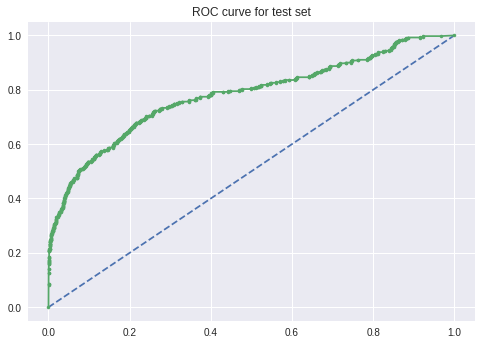

In [0]:
# calculate AUC of final model on a test set
probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = numpy.load('drive/My Drive/y_test.npy')  # osobno, bo inny wymiar

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC curve for test set')
pyplot.show()